#### Summary

The key to getting this project off to the ground is to correctly define validation and test sets ( as we will see later). Once we do that , we see that the validation error decreases correctly and remains in sync with the test error.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [4]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [5]:
INPUT_DIR = '../input/'
#INPUT_DIR = '../input/competitive-data-science-predict-future-sales/'

In [6]:
sales_train = pd.read_csv(INPUT_DIR + 'sales_train.csv')

In [7]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv')

#### Basic data checks (borrowed from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

NOTE: We are not using the price field, since we are not fully convinced on the data sanity of the same.

In [9]:
sales_train = sales_train[sales_train.item_cnt_day < 1001]
#sales_train = sales_train[sales_train.item_price < 100000]


In [24]:
shops = pd.read_csv(INPUT_DIR + 'shops.csv')
item_categories = pd.read_csv(INPUT_DIR + 'item_categories.csv')
items = pd.read_csv(INPUT_DIR + 'items.csv')
test = pd.read_csv(INPUT_DIR + 'test.csv')

ITEM_ID_TO_ITEM_CATEGORY_ID = dict(zip(items.item_id, items.item_category_id))

In [38]:
item_categories['cat_split']  = item_categories['item_category_name'].apply(lambda x : x.split('-'))

In [39]:
item_categories['type'] = item_categories['cat_split'].apply(lambda x : x[0])

In [40]:
item_categories['sub_type'] = item_categories['cat_split'].apply(lambda x : x[1] if len(x) > 1 else x[0])

In [41]:
item_categories['type_id'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['sub_type_id'] = LabelEncoder().fit_transform(item_categories['sub_type'])

In [42]:
ITEM_CATEGORY_ID_TO_TYPE_ID = dict(zip(item_categories.item_category_id, item_categories.type_id))
ITEM_CATEGORY_ID_TO_SUB_TYPE_ID = dict(zip(item_categories.item_category_id, item_categories.sub_type_id))

#### Get shops data

In [43]:
shops[(shops.shop_id == 0) | (shops.shop_id == 57)]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57


In [44]:
shops.loc[(shops.shop_id ==0), 'shop_id'] = 57

In [45]:
shops[(shops.shop_id == 1) | (shops.shop_id == 58)]

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


In [46]:
shops.loc[(shops.shop_id ==1), 'shop_id'] = 58

In [47]:
shops[(shops.shop_id == 11) | (shops.shop_id == 10)]

,shop_name,shop_id
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


In [48]:
shops.loc[(shops.shop_id ==10), 'shop_id'] = 11

In [50]:
### Make the city numeric
shops['city'] = shops['shop_name'].apply(lambda x : x.split()[0])
shops['city_id'] = LabelEncoder().fit_transform(shops['city'])

In [51]:
shops['city_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [52]:
SHOP_ID_TO_CITY_ID = dict(zip(shops.shop_id, shops.city_id))

#### Meat of the exercise.

Here comes the meat. Since the idea here is to increase more data, we do it in the following manner :

For every month, get a cartesian product of all shop_id's and item_id's and populate a dataframe with all these entries(for all months from 0 to 34). Then , populate this dataframe with feature values, which can be used for prediction.

On close observation, one can see that the test set is actually constructed in this way (you can verify that the total number of entries in the test set is the product of number of unique shop_id's and the number of unique item_id's).

In [13]:
from itertools import product
import time

In [14]:
def get_master_data_shop_id_item_id_corr_month():
    master_data = pd.DataFrame(columns=['date_block_num', 'shop_id', 'item_id'])
    for i in range(sales_train.date_block_num.max()+1):
        shop_id_item_ids = list(product(sales_train[sales_train.date_block_num==i].shop_id.unique(), 
                                        sales_train[sales_train.date_block_num==i].item_id.unique()))
        
        simple_df = pd.DataFrame(shop_id_item_ids, columns=['shop_id', 'item_id'])
        simple_df['date_block_num'] = i
        master_data = pd.concat([master_data, simple_df], sort=True)
    return master_data    

In [15]:
ts = time.time()
master_data = get_master_data_shop_id_item_id_corr_month()
time.time() - ts

29.69109606742859

#### Concatenating with a test set.

Now, that we have a master dataframe( and have encapsulated the methods so that we can switch between them easily), let us concate nate them with the test set.

In [16]:
test_data['date_block_num'] = 34

In [17]:
master_data_with_test = pd.concat([master_data, test_data[['date_block_num', 'shop_id', 'item_id']]], sort=True)

#### Now , let us start filling the dataframe with relevant feature data.

In [25]:
master_data_with_test['item_category_id'] = master_data_with_test.item_id.apply(
    lambda x : ITEM_ID_TO_ITEM_CATEGORY_ID.get(x, 0))

#### Add item_cnt_month

In [28]:
def get_monthly_data_from_daily(daily_data):
    monthly_data = daily_data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_day']].groupby(
        ['date_block_num', 'shop_id', 'item_id']).sum()
    monthly_data.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)
    monthly_data.reset_index(inplace=True)
    return monthly_data    

In [29]:
monthly_data= get_monthly_data_from_daily(sales_train)
monthly_data['present_in_orig_data'] = 1

In [30]:
master_data_with_test = pd.merge(master_data_with_test, 
                                 monthly_data, 
                                 on=['date_block_num', 'shop_id', 'item_id'],
                                 how='left')

In [31]:
master_data_with_test.fillna(0, inplace=True)
master_data_with_test['item_cnt_month'].clip(0, 20, inplace=True)

#### Let us build a sample model and see how it looks on this new data set.

In [34]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
def build_xgboost_model(X, Y, new_X, new_Y, X_COLUMNS, verbose_eval=False):
    xgb_train_data = xgb.DMatrix(X, Y, feature_names=X_COLUMNS)
    xgb_validation_data = xgb.DMatrix(new_X, new_Y, feature_names=X_COLUMNS)
    xgb_params = {'eta' : 0.1, 'eval_metric' : 'rmse'}
    model_obj = xgb.train(params=xgb_params,
                          dtrain=xgb_train_data,
                          num_boost_round=4000,
                          evals=[(xgb_validation_data, 'eval')],
                          early_stopping_rounds=10,
                          verbose_eval=verbose_eval)
    validation_predictions = model_obj.predict(xgb_validation_data, ntree_limit=model_obj.best_ntree_limit)
    prediction_score = np.sqrt(mean_squared_error(np.clip(validation_predictions, 0, 20), np.clip(new_Y, 0, 20)))
    #print(np.sqrt(mean_squared_error(validation_predictions, new_Y)))
    return (model_obj, prediction_score)

#### Pitfalls !

Remember that we have enlarged the data set by including entries for all shop_id's and item_id's for every month(and filling the missing values with zeros. While this is great for training, it is not great for validation as our validaiton score would be skewed by the presence of large number of zero entries. Hence we do the following :

1. Make sure that the training values are truncated at 20.

2. Make sure that the original validation data set is used as opposed to the inflated one (and make sure that the values are truncated at 20 as well).

#### Add more features.

Let us start with the item_cnt_month for the previous month.

In [35]:
def build_model_and_evaluate_validation_error(X_COLUMNS = ['date_block_num', 'shop_id', 'item_id', 'item_category_id'],
                                              Y_COLUMN = ['item_cnt_month'],
                                              master_data_with_test=master_data_with_test):
    train_X = master_data_with_test[master_data_with_test.date_block_num < 33][X_COLUMNS]
    train_Y = master_data_with_test[master_data_with_test.date_block_num < 33][Y_COLUMN]
    validation_X = master_data_with_test[
        (master_data_with_test.date_block_num == 33)][X_COLUMNS]
    validation_Y = master_data_with_test[
        (master_data_with_test.date_block_num == 33)][Y_COLUMN]
    (model_obj, prediction_score) = build_xgboost_model(train_X, train_Y, validation_X, validation_Y, X_COLUMNS)
    return (model_obj, prediction_score)

#### Add sales for previous month

In [36]:
# Ideal for creating features that correspond to that of previous month.
def get_lagged_feature(df, lags, feature_name):
    full_cols_list = ['date_block_num', 'shop_id', 'item_id'] + [feature_name]
    tmp = df[full_cols_list]
    for i in lags:
        shifted_df = tmp.copy()
        shifted_df['date_block_num'] += 1
        feature_new_col_name = feature_name + '_lag_' + str(i)
        shifted_df.rename(columns={feature_name:feature_new_col_name}, inplace=True)
        df = pd.merge(df, 
                      shifted_df,
                      on=['date_block_num', 'shop_id', 'item_id'],
                      how='left')
        df.fillna(0, inplace=True)
    return df


In [37]:
# Useful for creating features grouped by some columns followed by a time lag.
def get_lagged_feature_after_grouping(df, lags, grouped_cols, feature_col, new_feature_col_name ):
    all_cols = grouped_cols + [feature_col]
    grouped_data = df[all_cols].groupby(
        grouped_cols).mean()
    grouped_data.rename(columns={feature_col : new_feature_col_name}, inplace=True)
    grouped_data.reset_index(inplace=True)

    df = pd.merge(df,
                  grouped_data,
                  on=grouped_cols,
                  how='left')

    df = get_lagged_feature(df, lags, new_feature_col_name)    
    df.drop(columns=[new_feature_col_name], inplace=True)
    return df

#### Borrwing from https://www.kaggle.com/dlarionov/feature-engineering-xgboost, we code up relevant features.



In [53]:
ts = time.time()
master_data_with_test['month'] = master_data_with_test['date_block_num'] % 12
time.time() - ts

0.5500102043151855

In [54]:
ts = time.time()
master_data_with_test = get_lagged_feature(master_data_with_test,
                                           [1, 2, 3, 6, 12],
                                           'item_cnt_month')
time.time() - ts

84.34670114517212

In [55]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1, 2, 3, 6],
                                                          ['date_block_num', 'item_id'],
                                                          'item_cnt_month',
                                                          'date_item_avg_item_cnt_month')
time.time() - ts

87.53481793403625

In [72]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1],
                                                          ['date_block_num', 'shop_id', 'item_category_id'],
                                                          'item_cnt_month',
                                                          'date_shop_cat_avg_item_cnt_month')
time.time() - ts

35.49461793899536

In [58]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1],
                                                          ['date_block_num', 'item_category_id'],
                                                          'item_cnt_month',
                                                          'date_cat_avg_item_cnt_month')
time.time() - ts  

38.51128816604614

In [59]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1, 2, 3, 6, 12],
                                                          ['date_block_num', 'shop_id'],
                                                          'item_cnt_month',
                                                          'date_shop_avg_item_cnt_month')
time.time() - ts

135.94659996032715

In [60]:
from calendar import monthrange
def get_number_of_days_in_a_month(month, year=2013):
    return monthrange(year, month)[1]
get_number_of_days_in_a_month(3)

31

In [61]:
master_data_with_test['days'] = master_data_with_test.month.apply(lambda x : get_number_of_days_in_a_month(x+1))

In [62]:
master_data_with_test['city_id'] = master_data_with_test['shop_id'].apply(
     lambda x : SHOP_ID_TO_CITY_ID.get(x, -1))
master_data_with_test['type_id'] = master_data_with_test['item_category_id'].apply(
    lambda x : ITEM_CATEGORY_ID_TO_TYPE_ID.get(x, -1))
master_data_with_test['sub_type_id'] = master_data_with_test['item_category_id'].apply(
    lambda x : ITEM_CATEGORY_ID_TO_SUB_TYPE_ID.get(x, -1))

#### Add features based on city id.

In [63]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1],
                                                          ['date_block_num', 'item_id', 'city_id'],
                                                          'item_cnt_month',
                                                          'date_item_city_avg_item_cnt_month')
time.time() - ts

65.62280774116516

In [64]:
ts = time.time()
master_data_with_test = get_lagged_feature_after_grouping(master_data_with_test, 
                                                          [1],
                                                          ['date_block_num'],
                                                          'item_cnt_month',
                                                          'date_avg_item_cnt_month')
time.time() - ts

50.7128369808197

In [73]:
cur_x_cols = \
[x for x in list(master_data_with_test.columns) if x != 'item_cnt_month' and x != 'present_in_orig_data']


In [74]:
cur_x_cols

['date_block_num',
 'item_id',
 'shop_id',
 'item_category_id',
 'month',
 'item_cnt_month_lag_1',
 'item_cnt_month_lag_2',
 'item_cnt_month_lag_3',
 'item_cnt_month_lag_6',
 'item_cnt_month_lag_12',
 'date_item_avg_item_cnt_month_lag_1',
 'date_item_avg_item_cnt_month_lag_2',
 'date_item_avg_item_cnt_month_lag_3',
 'date_item_avg_item_cnt_month_lag_6',
 'date_cat_avg_item_cnt_month_lag_1',
 'date_shop_avg_item_cnt_month_lag_1',
 'date_shop_avg_item_cnt_month_lag_2',
 'date_shop_avg_item_cnt_month_lag_3',
 'date_shop_avg_item_cnt_month_lag_6',
 'date_shop_avg_item_cnt_month_lag_12',
 'days',
 'city_id',
 'type_id',
 'sub_type_id',
 'date_item_city_avg_item_cnt_month_lag_1',
 'date_avg_item_cnt_month_lag_1',
 'date_shop_cat_avg_item_cnt_month_lag_1']

##### Now, since some of the columns involve looking back a period of 12 months, we delete the data for the first 11 months before building a model to avoid the presence of a large number of zeros (Otherwise columns 'item_cnt_month_lag_12' and 'date_shop_avg_item_cnt_month_lag_12' would be completely zeros for the first 11 months).

In [75]:
master_data_with_test_new = master_data_with_test[master_data_with_test.date_block_num > 11]

In [76]:
ts = time.time()
(model_obj, prediction_score) = build_model_and_evaluate_validation_error(X_COLUMNS = cur_x_cols,
                                                                          Y_COLUMN = ['item_cnt_month'],
                                                                          master_data_with_test=master_data_with_test_new)
time.time() - ts

238.12424659729004

In [77]:
prediction_score

0.952011987935754

In [80]:
len(cur_x_cols)

27

In [78]:
from xgboost import plot_importance
def plot_feature_importances(model_obj):
    fig, ax = plt.subplots(1, 1, figsize=(16, 9))
    plot_importance(booster=model_obj, ax=ax)

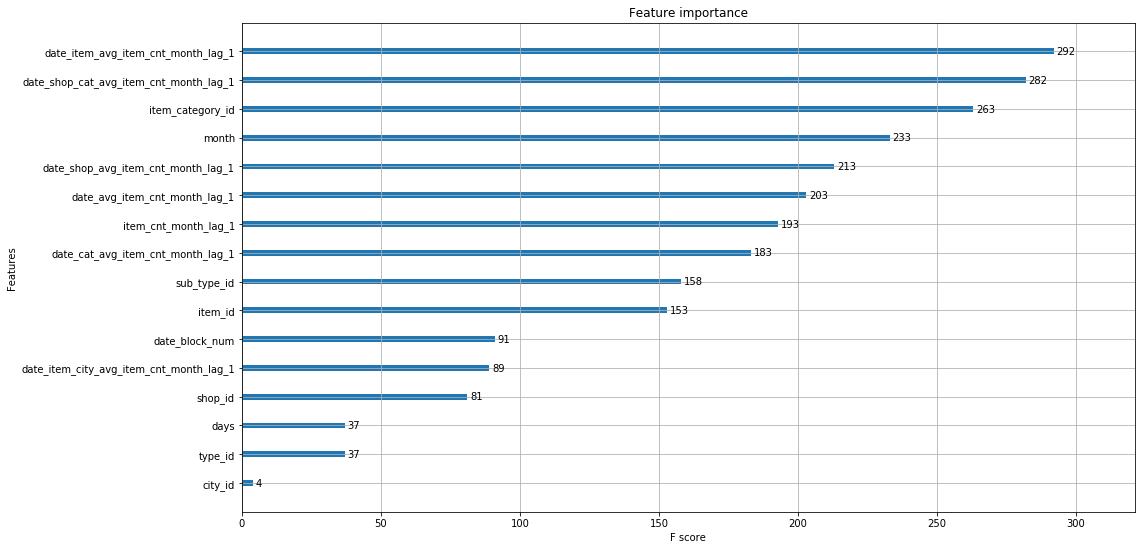

In [79]:
plot_feature_importances(model_obj)

#### Key idea to simplify the model.

We can do a trick here, that can help us in getting a good parsimonious model. First keep a superset of all predictors(they can be all significant ones according to the previous figure). Once we have that , we do the following :

1. Start with an empty list of predictors say pred_list.
2. Add a factor from the superset of predictors to pred_list and evaluate the validation error. Once we do this for all predictors in the superset, find which one has the lowest validation error and add the same to pred_list permanently.
3. Repeat steps 1 and 2 (note that we do not set pred_list to empty everytime, but rather only at the very beginning. In subsequent iterations, we persist the value of pred_list , that was obtained in the end of the previous iteration), until we do not see a decrease in validation error.

IMPORTANT NOTE : Since none of the features involve a big lookback window, we can safely train with the full data set and thus use a lot more data.



In [87]:
cur_x_cols = \
['item_category_id',
 'date_item_avg_item_cnt_month_lag_1',
 'item_id',
 'shop_id',
 'date_block_num',
 'item_cnt_month_lag_1',
 'date_shop_cat_avg_item_cnt_month_lag_1',
 'date_shop_avg_item_cnt_month_lag_1',
 'month', 'sub_type_id',
 'date_cat_avg_item_cnt_month_lag_1',
 'date_avg_item_cnt_month_lag_1',
 'date_item_city_avg_item_cnt_month_lag_1']
ts = time.time()
(model_obj, prediction_score) = build_model_and_evaluate_validation_error(X_COLUMNS = cur_x_cols,
                                                                          Y_COLUMN = ['item_cnt_month'],
                                                                          master_data_with_test=master_data_with_test)
time.time() - ts 

478.57609272003174

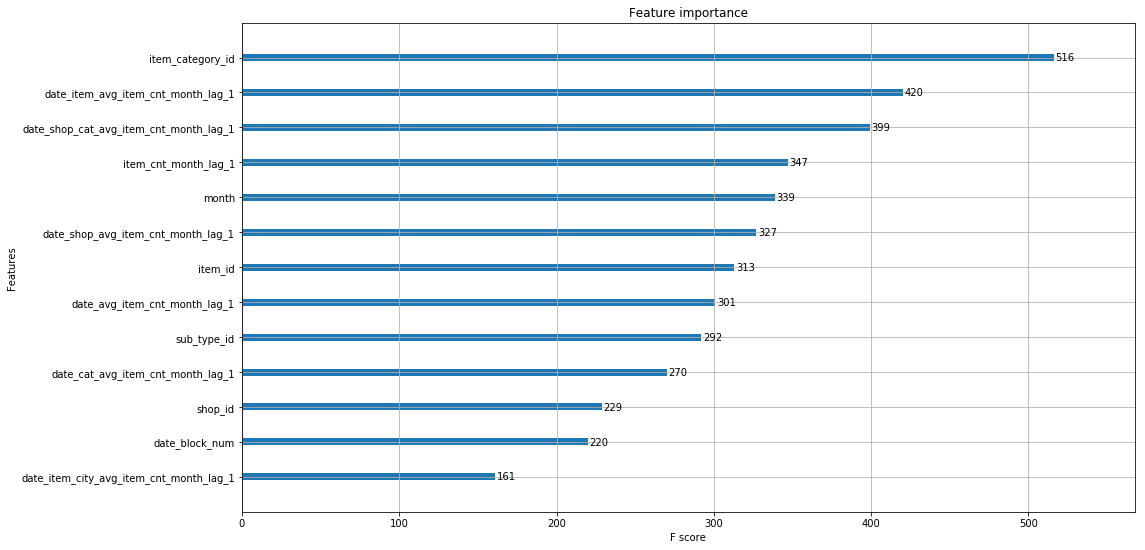

In [88]:
plot_feature_importances(model_obj)

In [89]:
prediction_score

0.9475363313452646

###### Thus we find a better score, when we work with only the most important predictors. Hence we do the following :

1. Drop the factor date_item_city_avg_item_cnt_month_lag_1 as it appears relatively insignificant and put the rest to a superset (having 12 predictors in total).
2. Apply the greedy algorithm described earlier to find the set of predictors that minimizes validation error.



In [ ]:
FULL_COLS_LIST = ['item_category_id',
 'date_item_avg_item_cnt_month_lag_1',
 'item_id',
 'shop_id',
 'date_block_num',
 'item_cnt_month_lag_1',
 'date_shop_cat_avg_item_cnt_month_lag_1',
 'date_shop_avg_item_cnt_month_lag_1',
 'month', 'sub_type_id',
 'date_cat_avg_item_cnt_month_lag_1']

In [ ]:
import operator
def get_prediction_scores_given_predictors(given_list, master_data_with_test_new=master_data_with_test_new):
    cols_list_to_score = {}
    for col in FULL_COLS_LIST:
        if col not in given_list:
            cols_list = given_list + [col]
            print(cols_list)
            score = build_model_and_evaluate_validation_error2_and_return_score_only(
                X_COLUMNS=cols_list,Y_COLUMN='item_cnt_month', master_data_with_test=master_data_with_test_new)
            cols_list_to_score[str(cols_list)] = score        
    
    return sorted(cols_list_to_score.items(), key=operator.itemgetter(1))

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors([])
time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors(['item_cnt_month_lag_1'])
time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors(['item_cnt_month_lag_1', 'sub_type_id'])
time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors(['item_cnt_month_lag_1', 'sub_type_id', 'shop_id'])
time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors(['item_cnt_month_lag_1', 'sub_type_id', 'shop_id', 'date_item_avg_item_cnt_month_lag_1'])
time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
#cols_list_to_score = get_prediction_scores_given_predictors(
#    ['item_cnt_month_lag_1', 'sub_type_id', 'shop_id', 'date_item_avg_item_cnt_month_lag_1', 'item_category_id'])

time.time() - ts

In [ ]:
cols_list_to_score

In [ ]:
ts = time.time()
# Commented out since operation is computation intensive and hence takes up a significant amount of time to complete.
# cols_list_to_score = get_prediction_scores_given_predictors(
#     ['item_cnt_month_lag_1', 
#      'sub_type_id', 
#      'shop_id', 
#      'date_item_avg_item_cnt_month_lag_1', 
#      'item_category_id', 
#      'item_id'])

time.time() - ts

In [ ]:
cols_list_to_score

In [96]:
cur_x_cols = \
['item_cnt_month_lag_1', 
 'item_category_id', 
 'shop_id', 
 'date_item_avg_item_cnt_month_lag_1', 
 'sub_type_id']
ts = time.time()
(model_obj, prediction_score) = build_model_and_evaluate_validation_error(X_COLUMNS = cur_x_cols,
                                                                          Y_COLUMN = ['item_cnt_month'],
                                                                          master_data_with_test=master_data_with_test)
print(time.time() - ts)
print(prediction_score)


620.5042827129364
0.9332173587251339


##### When we test only with recent data (I have not pasted the full analysis here, but it is rather to this one, except that we used a smaller dataset containing only most recent data), we have the following result.

In [93]:
cur_x_cols = ['item_cnt_month_lag_1', 
              'sub_type_id', 
              'shop_id', 
              'date_item_avg_item_cnt_month_lag_1', 
              'item_category_id', 
              'item_id',  
              'date_shop_cat_avg_item_cnt_month_lag_1']
ts = time.time()
(model_obj, prediction_score) = build_model_and_evaluate_validation_error(X_COLUMNS = cur_x_cols,
                                                                          Y_COLUMN = ['item_cnt_month'],
                                                                          master_data_with_test=master_data_with_test_new)
print(time.time() - ts)
print(prediction_score)


450.1988821029663
0.9154598617296164


#### Generate predictions for test data

In [94]:
def generate_test_data_predictions_and_write_to_file(filename='submission_xgboost_kaggle_notebook_replication.csv',
                                                     model_obj=model_obj,
                                                     master_data_with_test_new=master_data_with_test_new): 
    test_X = master_data_with_test_new[master_data_with_test_new.date_block_num == 34][cur_x_cols]
    test_predictions = model_obj.predict(xgb.DMatrix(test_X, feature_names=cur_x_cols)).clip(0, 20)
    test_data_with_predictions = test_data.copy()
    test_data_with_predictions['item_cnt_month'] = test_predictions
    test_data_with_predictions[['ID', 'item_cnt_month']].to_csv(filename, index=False)

In [101]:
generate_test_data_predictions_and_write_to_file(filename='submission_xgboost_most_optimal_model.csv')